In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear_marginalized.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])
PZ = [0]*nz
for i in range(nz):
    z = np.concatenate([np.linspace(-0.5, 0, 100), pz_fid[i].get_knots()[1:]])
    p = np.concatenate([np.zeros(100), pz_fid[i](pz_fid[i].get_knots()[1:])])
    PZ[i] = interpolate.InterpolatedUnivariateSpline(z, p, k = 3)
pz_fid = PZ

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
npar = 15

# Define the priors
lower = np.zeros(npar)
upper = np.zeros(npar)
lower[0:5] = np.array([0, 0.4, 0, 0.4, 0.7])
lower[5:] = np.ones(nz)*-0.1
upper[0:5] = np.array([1, 1.2, 0.1, 1.0, 1.3])
upper[5:] = np.ones(nz)*0.1
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
sigmas[5:] = np.ones(nz)*0.05
S = np.eye(npar)*sigmas**2
Sinv = np.linalg.inv(S)
prior_args = [prior_mean, S, lower, upper]

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.concatenate([abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.1, 0.1, 0.05]), np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])])
dCdt = np.zeros((npar, nz, nz, len(modes)))
# Derivatives wrt cosmological parameters
for i in range(npar-nz):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])
    
# Derivatives wrt photo-z bias parameters
for i in range(nz):
    
    pzprime = [interpolate.InterpolatedUnivariateSpline(np.linspace(0, pz_fid[0].get_knots()[-1], len(pz_fid[0].get_knots())), np.zeros(len(pz_fid[0].get_knots()))) for X in range(nz)]
    pzprime[i] = pz_fid[i].derivative()
    dCdt[npar-nz+i, :, :, :] = d_power_spectrum_db(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz)), pzprime])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Sinv)

# Compute projection matrices
Fpinv = np.linalg.inv(F[5:,5:])
P = np.zeros((5, 10))
for i in range(5):
    P[i,:] = np.dot(Fpinv, F[i,5:])

# Projection arguments
projection_args = [Finv, P, theta_fiducial, fisher_errors, prior_mean, Sinv, Cinv, dCdt, modes, nl]

# SimABC args
simulator_args = [sim_args, projection_args, prior_args]

# Now do the set up for the nuisance projected problem...
npar = 5
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Q = np.eye(npar)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
Finv = Finv[0:npar, 0:npar]
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
def simulator(x, *args):

    return simulationABC(x, args[0])

In [4]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [6]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, simulator_args = simulator_args, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 12s 1ms/step - loss: 32.7926 - val_loss: 15.6653
Epoch 2/100
9000/9000 [==============================] - 12s 1ms/step - loss: 14.7391 - val_loss: 14.0933
Epoch 3/100
9000/9000 [==============================] - 12s 1ms/step - loss: 13.7816 - val_loss: 13.4756
Epoch 4/100
9000/9000 [==============================] - 13s 1ms/step - loss: 13.2726 - val_loss: 13.0611
Epoch 5/100
9000/9000 [==============================] - 20s 2ms/step - loss: 12.8713 - val_loss: 12.6877
Epoch 6/100
9000/9000 [==============================] - 17s 2ms/step - loss: 12.5362 - val_loss: 12.4620
Epoch 7/100
9000/9000 [==============================] - 13s 1ms/step - loss: 12.2577 - val_loss: 12.0571
Epoch 8/100
9000/9000 [==============================] - 13s 1ms/step - loss: 11.9081 - val_loss: 11.7521
Epoch 9/100
9000/9000 [============

9000/9000 [==============================] - 15s 2ms/step - loss: 5.8189 - val_loss: 6.0527
Epoch 78/100
9000/9000 [==============================] - 13s 1ms/step - loss: 5.7825 - val_loss: 5.7854
Epoch 79/100
9000/9000 [==============================] - 14s 2ms/step - loss: 5.6981 - val_loss: 5.7285
Epoch 80/100
9000/9000 [==============================] - 13s 1ms/step - loss: 5.7055 - val_loss: 5.8170
Epoch 81/100
9000/9000 [==============================] - 14s 2ms/step - loss: 5.7991 - val_loss: 6.0360
Epoch 82/100
9000/9000 [==============================] - 16s 2ms/step - loss: 5.6578 - val_loss: 5.7046
Epoch 83/100
9000/9000 [==============================] - 14s 2ms/step - loss: 5.6034 - val_loss: 5.5680
Epoch 84/100
9000/9000 [==============================] - 14s 2ms/step - loss: 5.5752 - val_loss: 5.5635
Epoch 85/100
9000/9000 [==============================] - 13s 1ms/step - loss: 5.5970 - val_loss: 5.5893
Epoch 86/100
9000/9000 [==============================] - 14s 2ms/st

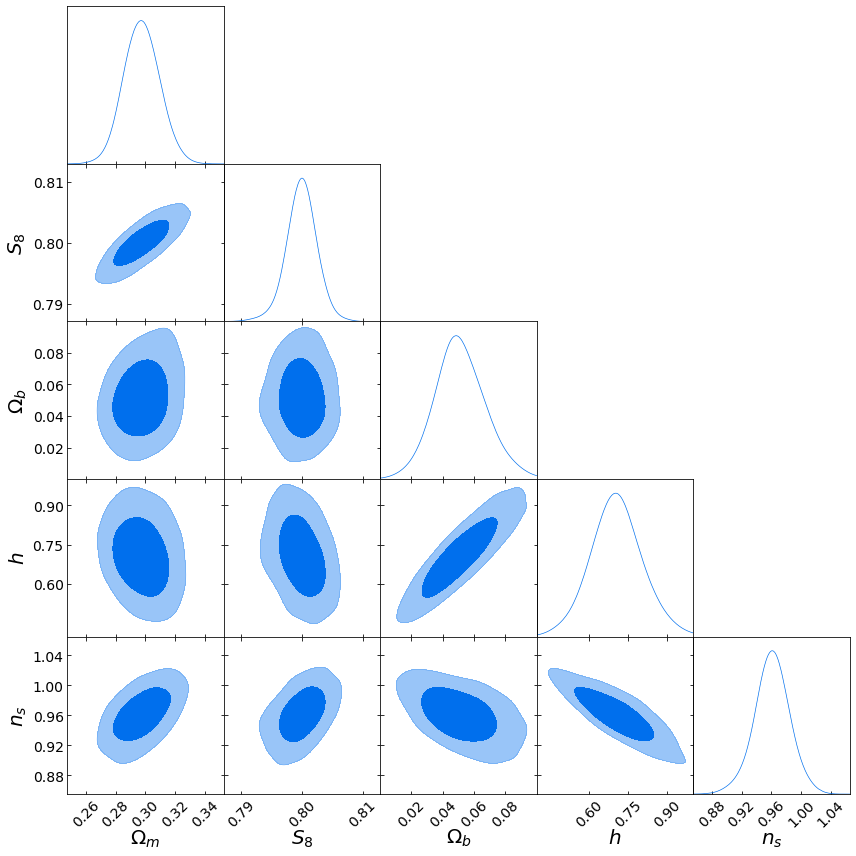

In [7]:
# Do the Fisher pre-training
mdn.fisher_pretraining(10000, prior, epochs=100)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 1ms/step - loss: 8.4955 - val_loss: 8.4081
Epoch 2/100
450/450 [==============================] - 1s 1ms/step - loss: 6.9251 - val_loss: 7.7530
Epoch 3/100
450/450 [==============================] - 1s 1ms/step - loss: 6.2530 - val_loss: 6.9703
Epoch 4/100
450/450 [==============================] - 1s 1ms/step - loss: 5.8613 - val_loss: 6.0039
Epoch 5/100
450/450 [==============================] - 1s 1ms/step - loss: 5.5403 - val_loss: 5.6256
Epoch 6/100
450/450 [==============================] - 1s 1ms/step - loss: 5.3353 - val_loss: 5.4275
Epoch 7/100
450/450 [==============================] - 1s 1ms/step - loss: 5.2654 - val_loss: 5.4078
Epoch 8/100
450/450 [==============================] - 1s 1ms/step - loss: 5.0823 - val_loss: 5.4359
Epoch 9/100
450/450 [==============================] - 1s 1ms/step - loss: 5.0391 - val_loss: 5.5190
Epoch 10/100

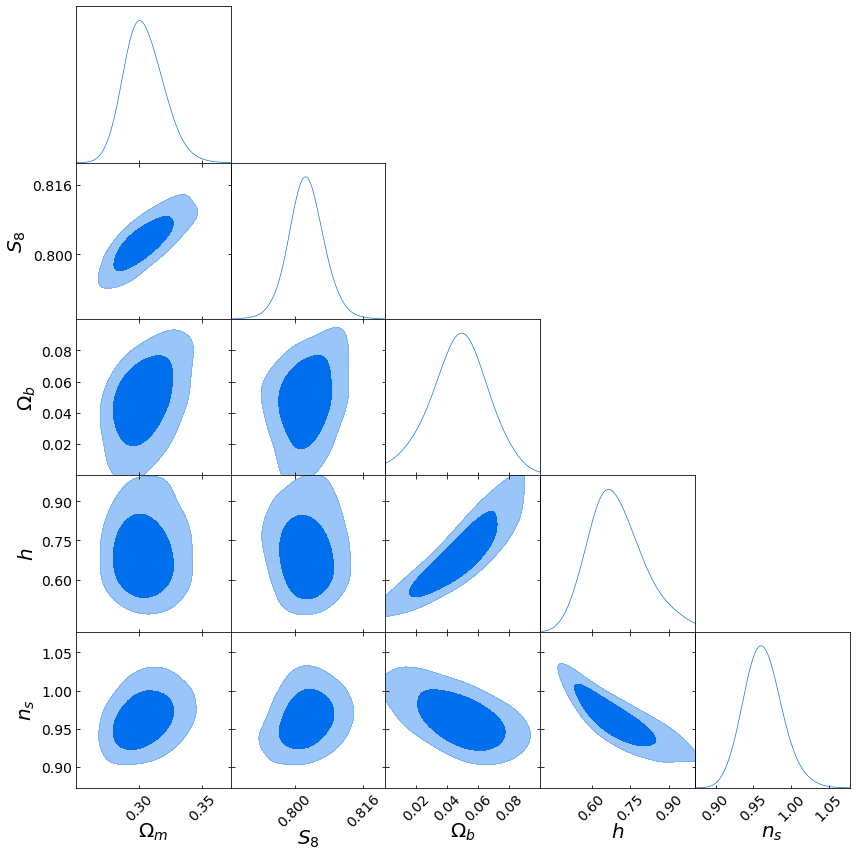

Population 1/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 4.3817 - val_loss: 4.4625
Epoch 2/100
900/900 [==============================] - 1s 1ms/step - loss: 4.3147 - val_loss: 4.2210
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 4.2516 - val_loss: 4.1487
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 4.2550 - val_loss: 4.1991
Epoch 5/100
900/900 [==============================] - 1s 1ms/step - loss: 4.2292 - val_loss: 4.1608
Epoch 6/100
900/900 [==============================] - 1s 1ms/step - loss: 4.2565 - val_loss: 4.1424
Epoch 7/100
900/900 [==============================] - 1s 1ms/step - loss: 4.2357 - val_loss: 4.2808
Epoch 8/100
900/900 [==============================] - 1s 1ms/step - loss: 4.1939 - val_loss: 4.1442
Epoch 9/100
900/900 [==============================] - 1s 1ms/step - 

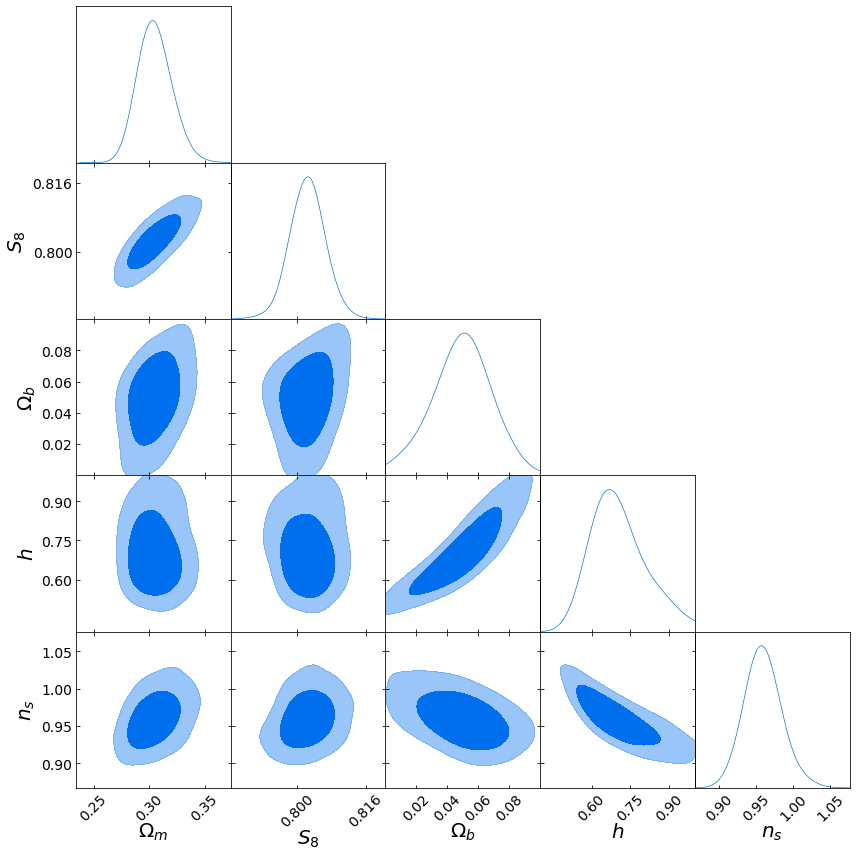

Population 2/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.2316 - val_loss: 4.2353
Epoch 2/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1902 - val_loss: 4.1499
Epoch 3/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1582 - val_loss: 4.1992
Epoch 4/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1727 - val_loss: 4.1393
Epoch 5/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1546 - val_loss: 4.2174
Epoch 6/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1602 - val_loss: 4.1919
Epoch 7/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.2125 - val_loss: 4.2250
Epoch 8/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1845 - val_loss: 4.1614
Epoch 9/100
1350/1350 [=============================

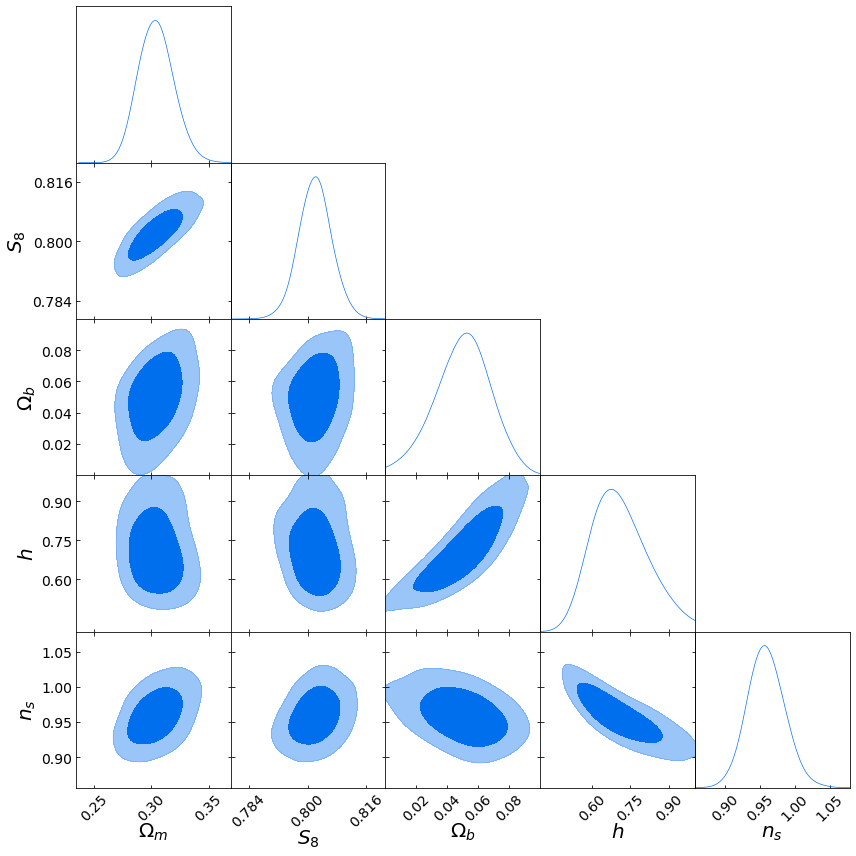

Population 3/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1353 - val_loss: 4.0452
Epoch 2/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1167 - val_loss: 4.1242
Epoch 3/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1253 - val_loss: 4.0437
Epoch 4/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.0962 - val_loss: 4.1535
Epoch 5/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1946 - val_loss: 4.0848
Epoch 6/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1439 - val_loss: 4.1613
Epoch 7/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1387 - val_loss: 4.0299
Epoch 8/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.0844 - val_loss: 4.0140
Epoch 9/100
1800/1800 [=============================

1800/1800 [==============================] - 2s 1ms/step - loss: 4.0676 - val_loss: 4.0555
Epoch 79/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.0443 - val_loss: 3.9986
Epoch 80/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.0598 - val_loss: 4.1857
Epoch 81/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1412 - val_loss: 4.0797
Epoch 82/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1003 - val_loss: 4.0413
Epoch 83/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.0437 - val_loss: 3.9968
Epoch 84/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.0291 - val_loss: 4.2541
Epoch 85/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.1034 - val_loss: 3.9629
Epoch 86/100
1800/1800 [==============================] - 2s 1ms/step - loss: 4.0580 - val_loss: 4.0670
Epoch 87/100
1800/1800 [==============================] - 2s 1ms/step - loss:

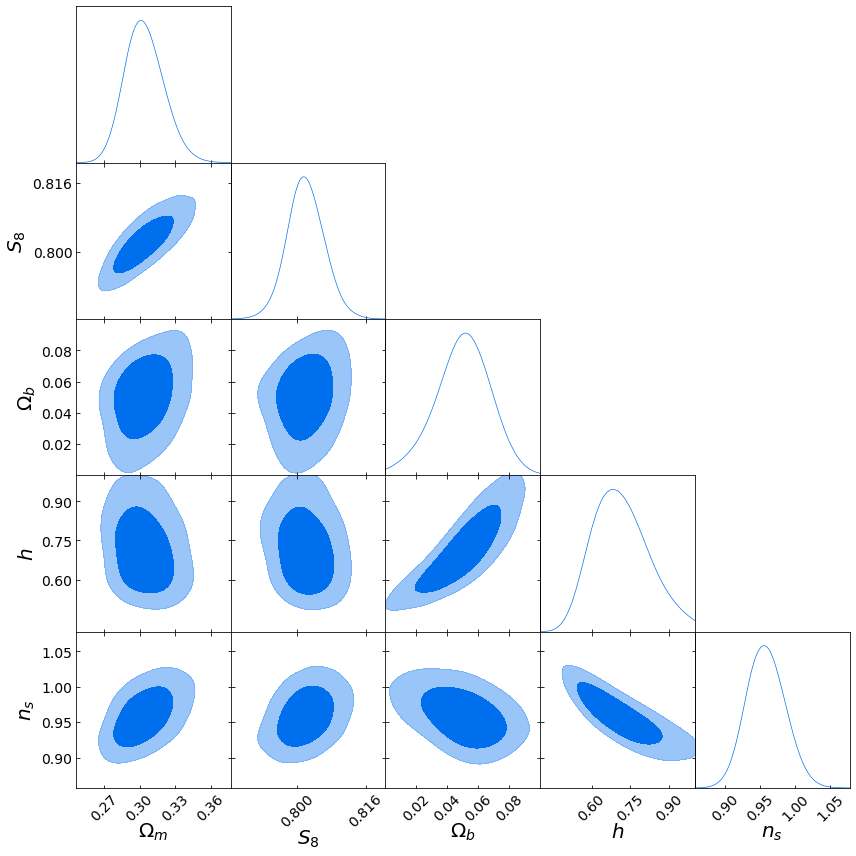

Population 4/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.0653 - val_loss: 3.9729
Epoch 2/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.0627 - val_loss: 3.9837
Epoch 3/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.0416 - val_loss: 4.0579
Epoch 4/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.1163 - val_loss: 4.0431
Epoch 5/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.1209 - val_loss: 3.9846
Epoch 6/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.1063 - val_loss: 4.0708
Epoch 7/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.0604 - val_loss: 3.9468
Epoch 8/100
2250/2250 [==============================] - 3s 1ms/step - loss: 4.0303 - val_loss: 3.9498
Epoch 9/100
2250/2250 [=============================

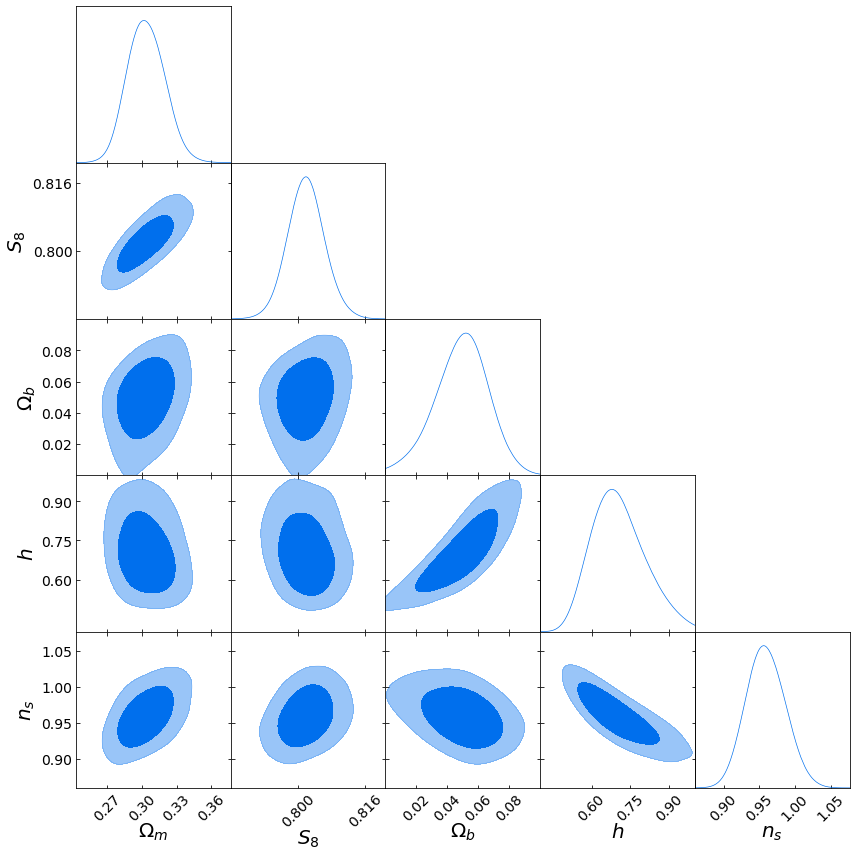

Population 5/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0206 - val_loss: 3.9156
Epoch 2/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0184 - val_loss: 3.9495
Epoch 3/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0255 - val_loss: 3.9742
Epoch 4/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0386 - val_loss: 3.9496
Epoch 5/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0377 - val_loss: 3.9554
Epoch 6/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0197 - val_loss: 3.9524
Epoch 7/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0377 - val_loss: 3.9396
Epoch 8/100
2700/2700 [==============================] - 4s 1ms/step - loss: 4.0100 - val_loss: 4.0054
Epoch 9/100
2700/2700 [=============================

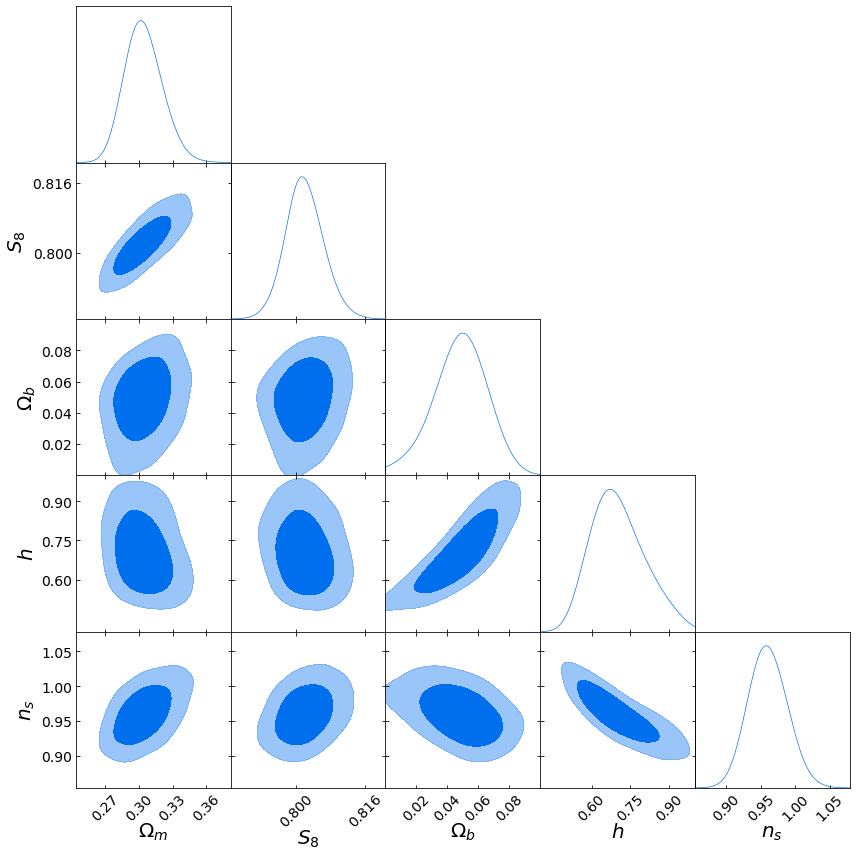

Population 6/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 4s 1ms/step - loss: 4.0315 - val_loss: 3.9612
Epoch 2/100
3150/3150 [==============================] - 4s 1ms/step - loss: 4.0302 - val_loss: 3.8833
Epoch 3/100
3150/3150 [==============================] - 4s 1ms/step - loss: 4.0235 - val_loss: 3.8744
Epoch 4/100
3150/3150 [==============================] - 4s 1ms/step - loss: 4.0007 - val_loss: 3.8661
Epoch 5/100
3150/3150 [==============================] - 4s 1ms/step - loss: 3.9875 - val_loss: 3.8976
Epoch 6/100
3150/3150 [==============================] - 4s 1ms/step - loss: 3.9922 - val_loss: 3.8855
Epoch 7/100
3150/3150 [==============================] - 4s 1ms/step - loss: 3.9980 - val_loss: 3.8694
Epoch 8/100
3150/3150 [==============================] - 4s 1ms/step - loss: 3.9893 - val_loss: 3.8933
Epoch 9/100
3150/3150 [=============================

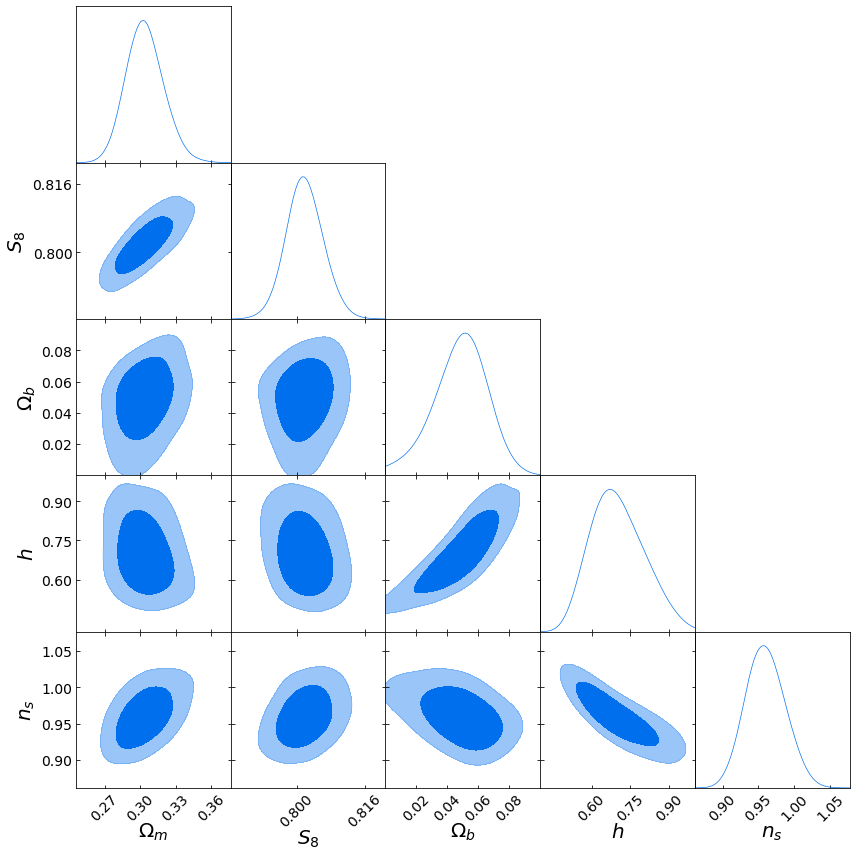

Population 7/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.9705 - val_loss: 4.0576
Epoch 2/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.9720 - val_loss: 4.0960
Epoch 3/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.9781 - val_loss: 4.0681
Epoch 4/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.9800 - val_loss: 4.1299
Epoch 5/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.9923 - val_loss: 4.0995
Epoch 6/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.9987 - val_loss: 4.0899
Epoch 7/100
3600/3600 [==============================] - 5s 1ms/step - loss: 4.0058 - val_loss: 4.2006
Epoch 8/100
3600/3600 [==============================] - 5s 1ms/step - loss: 4.0179 - val_loss: 4.0601
Epoch 9/100
3600/3600 [=============================

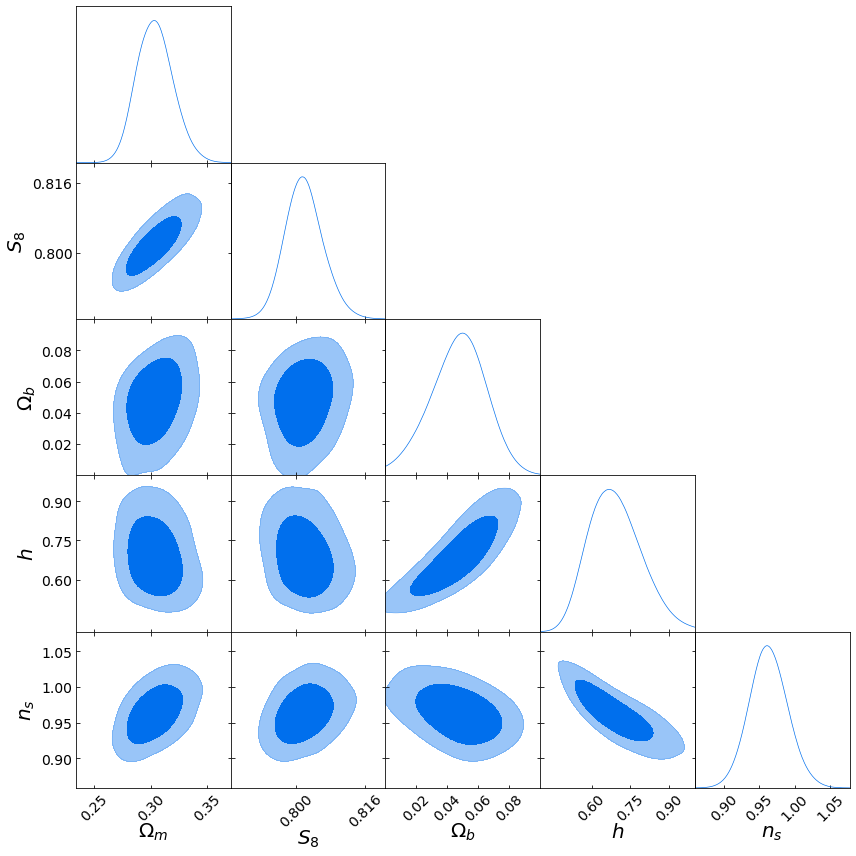

Population 8/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9667 - val_loss: 3.8683
Epoch 2/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9744 - val_loss: 3.8816
Epoch 3/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9882 - val_loss: 3.8414
Epoch 4/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9841 - val_loss: 3.8623
Epoch 5/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9815 - val_loss: 3.8853
Epoch 6/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9802 - val_loss: 3.9199
Epoch 7/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9771 - val_loss: 3.8611
Epoch 8/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.9627 - val_loss: 3.8899
Epoch 9/100
4050/4050 [=============================

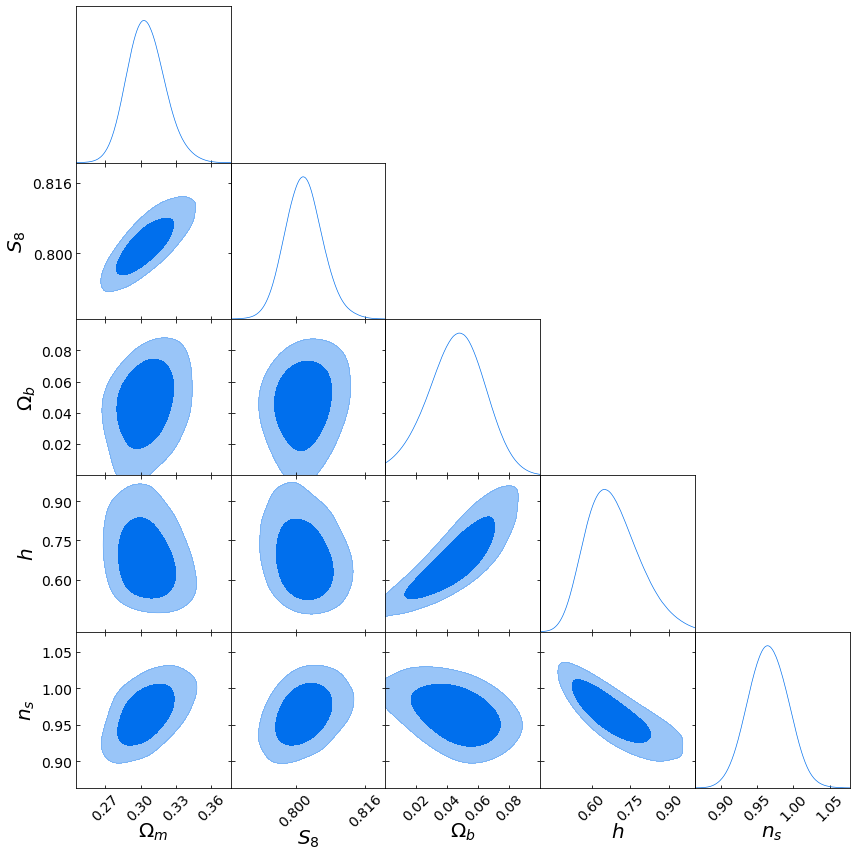

Population 9/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9586 - val_loss: 4.0252
Epoch 2/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9574 - val_loss: 4.0564
Epoch 3/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9588 - val_loss: 4.0421
Epoch 4/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9595 - val_loss: 4.0443
Epoch 5/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9565 - val_loss: 4.0409
Epoch 6/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9514 - val_loss: 4.0427
Epoch 7/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9507 - val_loss: 4.0487
Epoch 8/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.9644 - val_loss: 4.0676
Epoch 9/100
4500/4500 [=============================

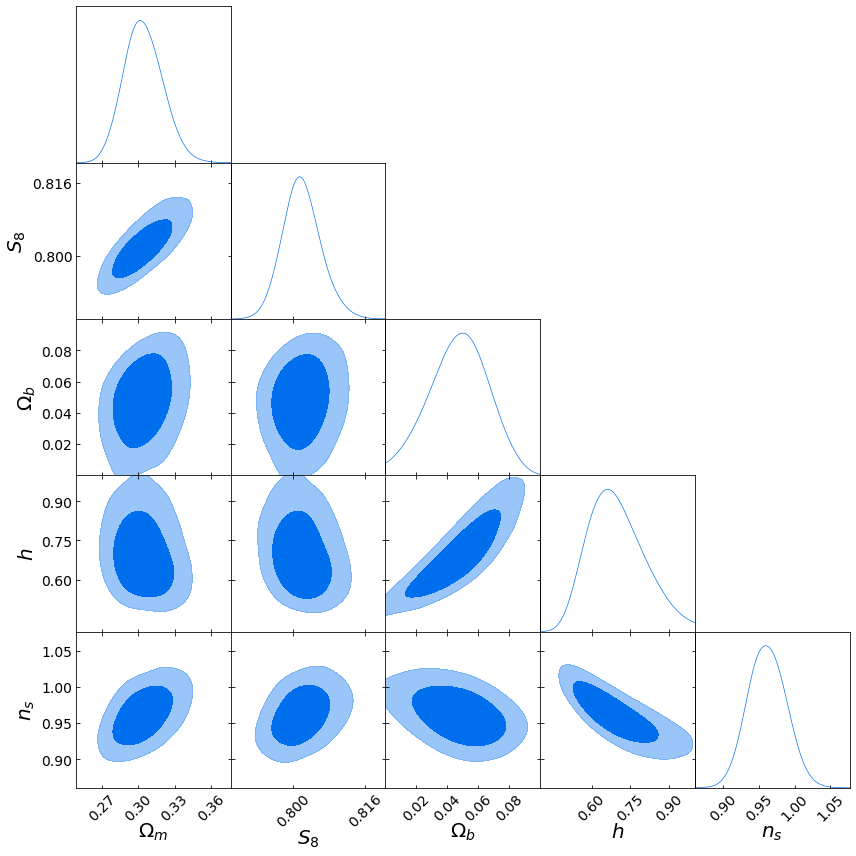

Population 10/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4950 samples, validate on 550 samples
Epoch 1/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9595 - val_loss: 4.0993
Epoch 2/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9544 - val_loss: 4.1118
Epoch 3/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9613 - val_loss: 4.0993
Epoch 4/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9637 - val_loss: 4.1058
Epoch 5/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9525 - val_loss: 4.1041
Epoch 6/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9601 - val_loss: 4.1120
Epoch 7/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9590 - val_loss: 4.0989
Epoch 8/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.9567 - val_loss: 4.0924
Epoch 9/100
4950/4950 [============================

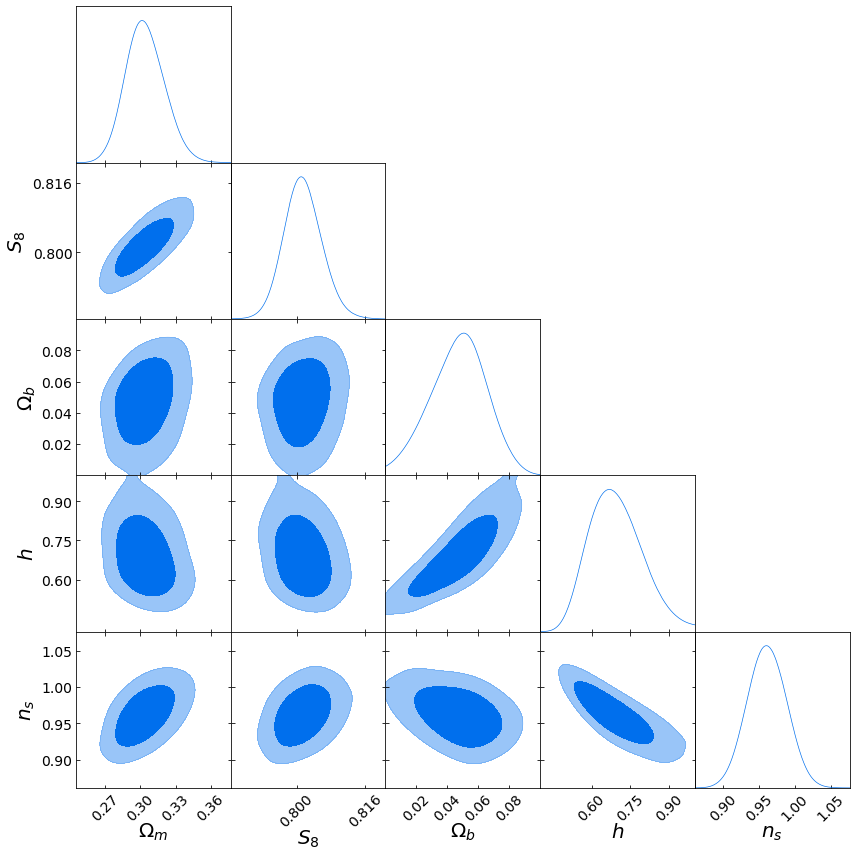

Population 11/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9720 - val_loss: 3.9377
Epoch 2/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9743 - val_loss: 3.9484
Epoch 3/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9569 - val_loss: 3.9612
Epoch 4/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9708 - val_loss: 3.9520
Epoch 5/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9701 - val_loss: 3.9609
Epoch 6/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9709 - val_loss: 3.9693
Epoch 7/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9909 - val_loss: 3.9674
Epoch 8/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.9793 - val_loss: 3.9448
Epoch 9/100
5400/5400 [============================

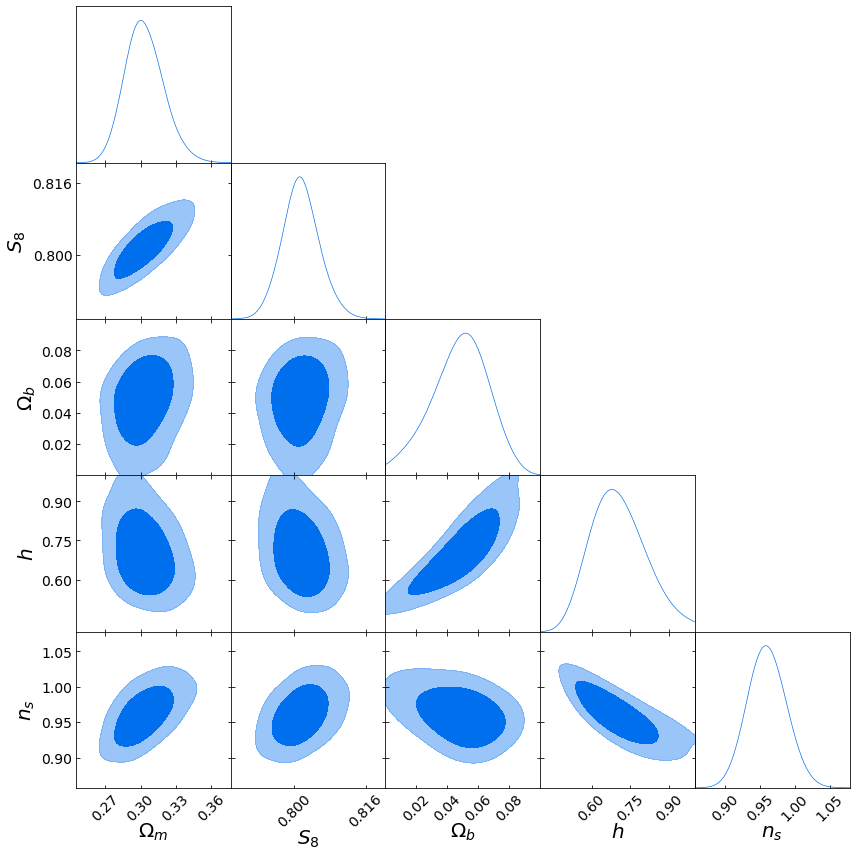

Population 12/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5850 samples, validate on 650 samples
Epoch 1/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9660 - val_loss: 4.1457
Epoch 2/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9531 - val_loss: 4.1454
Epoch 3/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9513 - val_loss: 4.1287
Epoch 4/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9490 - val_loss: 4.1433
Epoch 5/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9491 - val_loss: 4.1439
Epoch 6/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9658 - val_loss: 4.1412
Epoch 7/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9523 - val_loss: 4.1444
Epoch 8/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.9422 - val_loss: 4.1613
Epoch 9/100
5850/5850 [============================

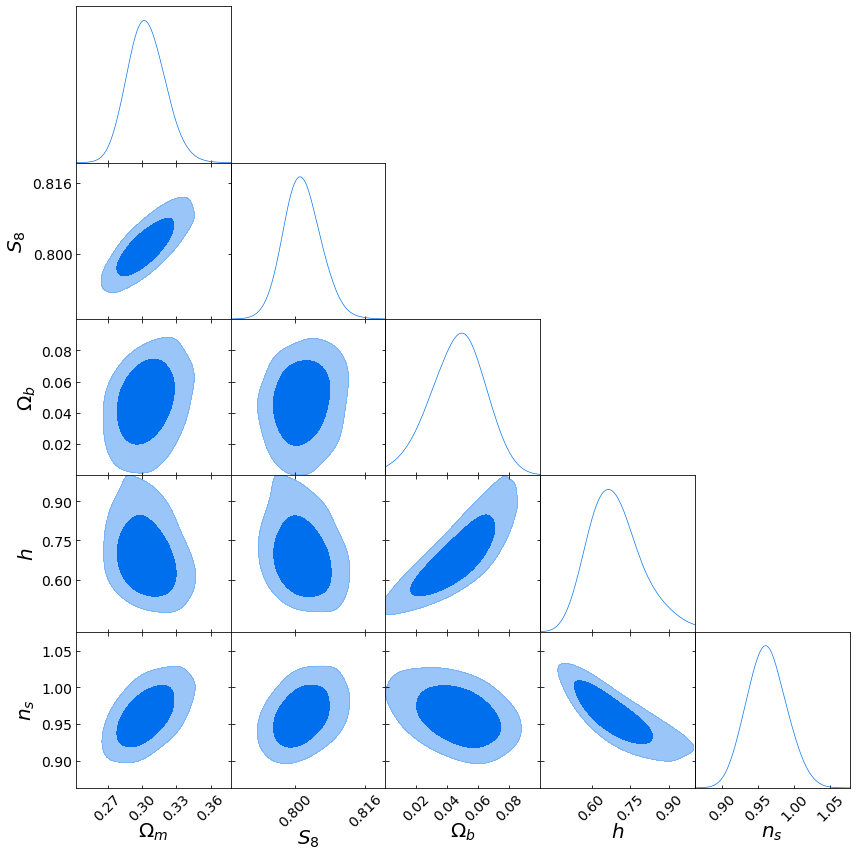

Population 13/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.9703 - val_loss: 3.9180
Epoch 2/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.9952 - val_loss: 3.9305
Epoch 3/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.9895 - val_loss: 3.9224
Epoch 4/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.9815 - val_loss: 3.8850
Epoch 5/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.9741 - val_loss: 3.9558
Epoch 6/100
6300/6300 [==============================] - 9s 1ms/step - loss: 4.0103 - val_loss: 3.8891
Epoch 7/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.9881 - val_loss: 3.9906
Epoch 8/100
6300/6300 [==============================] - 9s 1ms/step - loss: 4.0031 - val_loss: 3.8887
Epoch 9/100
6300/6300 [============================

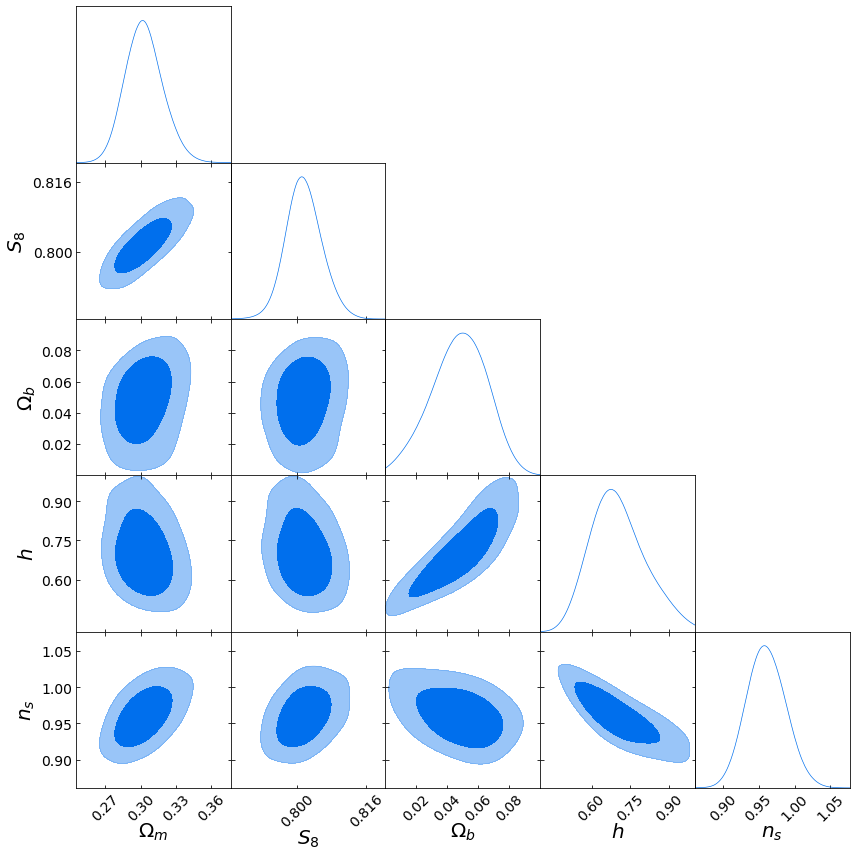

Population 14/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 10s 1ms/step - loss: 3.9704 - val_loss: 4.0062
Epoch 2/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.9659 - val_loss: 3.9641
Epoch 3/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.9451 - val_loss: 3.9909
Epoch 4/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.9540 - val_loss: 4.0264
Epoch 5/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.9663 - val_loss: 3.9754
Epoch 6/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.9432 - val_loss: 3.9836
Epoch 7/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.9448 - val_loss: 3.9713
Epoch 8/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.9439 - val_loss: 3.9859
Epoch 9/100
6750/6750 [===========================

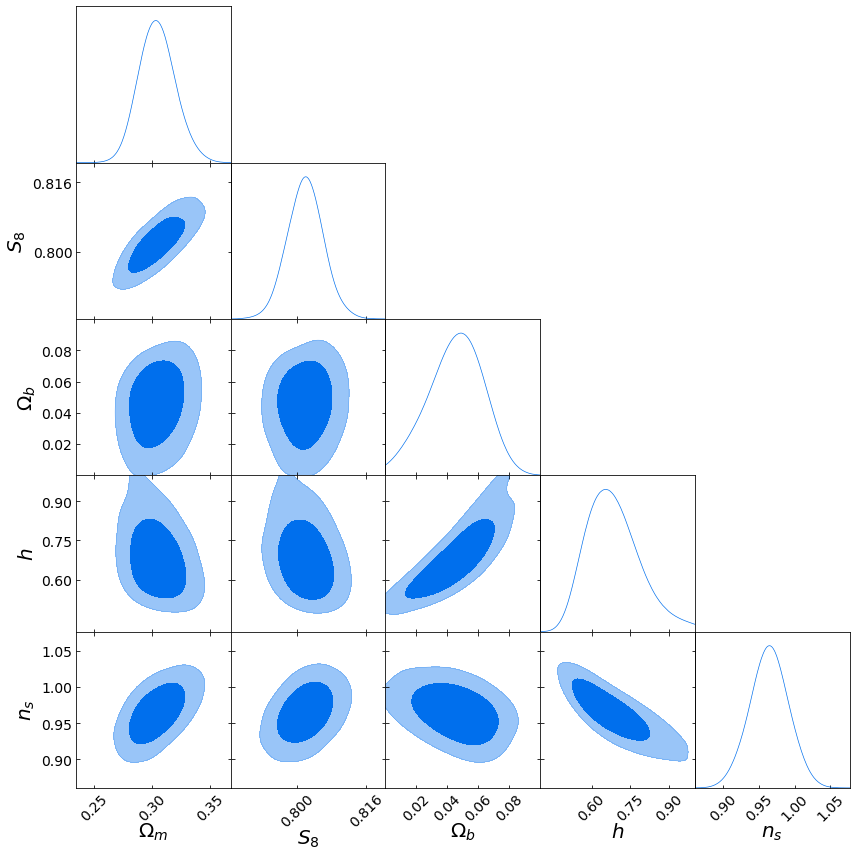

Population 15/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.9496 - val_loss: 4.0026
Epoch 2/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.9465 - val_loss: 4.0651
Epoch 3/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.9639 - val_loss: 3.9934
Epoch 4/100
7200/7200 [==============================] - 18s 2ms/step - loss: 3.9430 - val_loss: 3.9893
Epoch 5/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.9418 - val_loss: 3.9915
Epoch 6/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.9373 - val_loss: 3.9915
Epoch 7/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.9374 - val_loss: 3.9908
Epoch 8/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.9373 - val_loss: 4.0006
Epoch 9/100
7200/7200 [====================

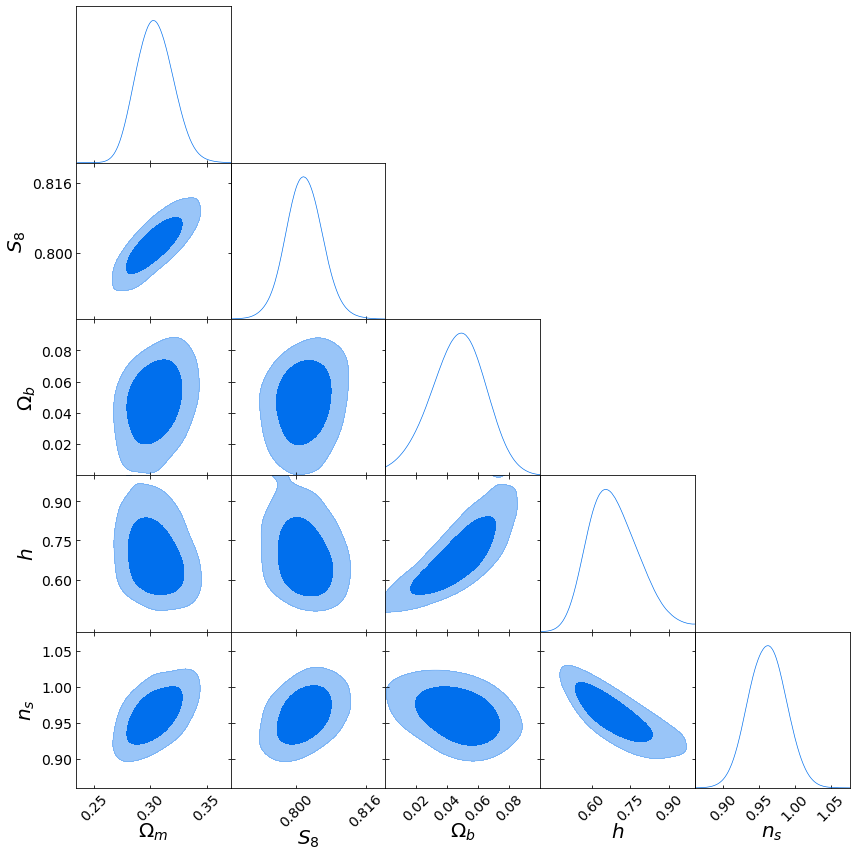

Final round of training with larger SGD batch size...
Train on 7200 samples, validate on 800 samples
Epoch 1/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9710 - val_loss: 3.9859
Epoch 2/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9319 - val_loss: 4.0240
Epoch 3/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9762 - val_loss: 3.9815
Epoch 4/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9264 - val_loss: 4.0126
Epoch 5/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9572 - val_loss: 3.9915
Epoch 6/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9330 - val_loss: 4.0380
Epoch 7/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9510 - val_loss: 3.9932
Epoch 8/300
7200/7200 [==============================] - 21s 3ms/step - loss: 3.9222 - val_loss: 3.9943
Epoch 9/300
7200/7200 [==============================] - 21s 3ms/st

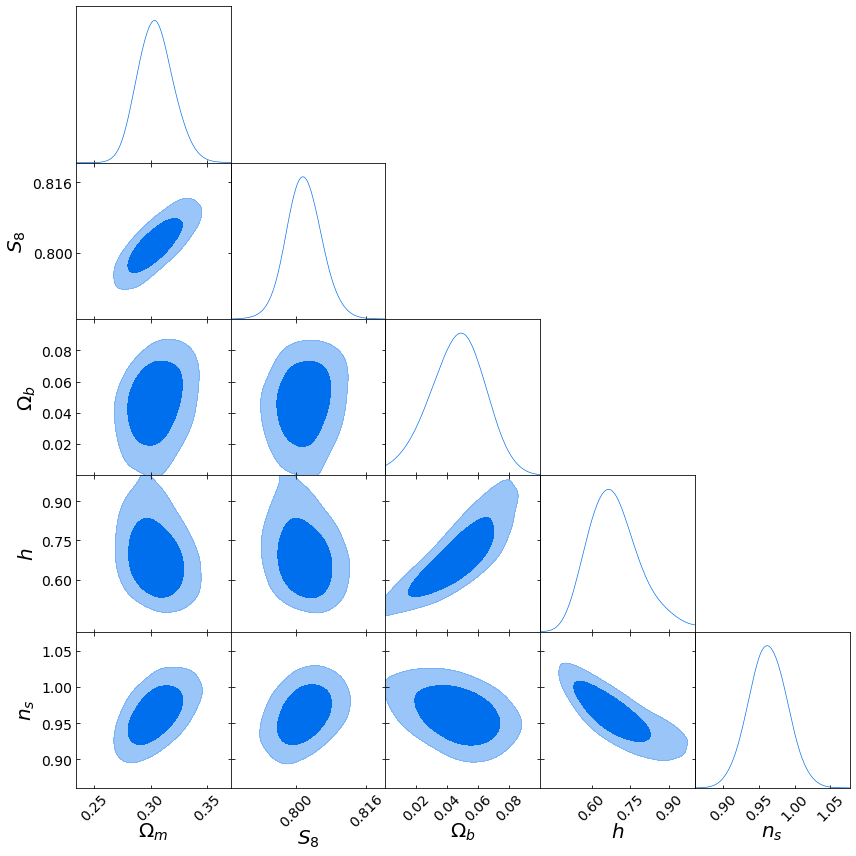

In [8]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

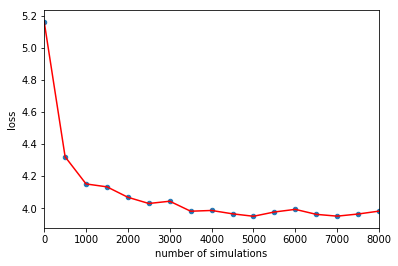

In [9]:
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()